<a href="https://colab.research.google.com/github/Ayoits-Vijay/Movie-Booking-App/blob/master/LiTS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!find /content/drive/MyDrive -name "*Training_Batch1.zip"


/content/drive/MyDrive/Training_Batch1.zip


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/Training_Batch1.zip"  # ← use the path you found
extract_path = "/content/LiTS_Extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import os

# Explore the folder structure to find .nii files
for root, dirs, files in os.walk("/content/LiTS_Extracted"):
    for f in files:
        if f.endswith(".nii") or f.endswith(".nii.gz"):
            print(os.path.join(root, f))


/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-11.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-16.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-5.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-14.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-10.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-11.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-18.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-21.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-4.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-16.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-24.nii
/content/LiTS_Extracted/m

In [ ]:
volume_path = "FULL/PATH/TO/volume-0.nii"
mask_path = "FULL/PATH/TO/segmentation-0.nii"


In [ ]:
import nibabel as nib
import numpy as np
import os
from PIL import Image

# Set your dataset folder path
dataset_folder = "/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/"

# Example filenames (change index for other pairs)
volume_filename = "volume-0.nii"
mask_filename = "segmentation-0.nii"

# Full paths
volume_path = os.path.join(dataset_folder, volume_filename)
mask_path = os.path.join(dataset_folder, mask_filename)

# Output folders for slices
output_img_dir = "/content/slices/images/"
output_mask_dir = "/content/slices/masks/"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Load volumes
volume = nib.load(volume_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

# Normalize volume for 8-bit PNG saving
volume_norm = (volume - np.min(volume)) / (np.max(volume) - np.min(volume)) * 255
volume_norm = volume_norm.astype(np.uint8)
mask = mask.astype(np.uint8)

# Extract and save slices
for i in range(volume.shape[2]):
    img_slice = Image.fromarray(volume_norm[:, :, i])
    # Mask can have multiple labels, scale for visualization
    mask_slice = Image.fromarray((mask[:, :, i] > 0).astype(np.uint8) * 255)

    img_slice.save(os.path.join(output_img_dir, f"image_{i:03d}.png"))
    mask_slice.save(os.path.join(output_mask_dir, f"mask_{i:03d}.png"))

print("Slices saved!")


Slices saved!


In [ ]:
import os
import shutil
import random

# Paths to your slices folders
img_dir = "/content/slices/images/"
mask_dir = "/content/slices/masks/"

# Output split folders
train_img_dir = "/content/dataset/train/images/"
train_mask_dir = "/content/dataset/train/masks/"
val_img_dir = "/content/dataset/val/images/"
val_mask_dir = "/content/dataset/val/masks/"

for d in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir]:
    os.makedirs(d, exist_ok=True)

# Get all slice filenames (assumes masks have matching names)
all_images = sorted(os.listdir(img_dir))

# Shuffle and split (80% train, 20% val)
random.seed(42)
random.shuffle(all_images)
split_idx = int(len(all_images)*0.8)
train_files = all_images[:split_idx]
val_files = all_images[split_idx:]

def copy_files(file_list, src_img_dir, src_mask_dir, dst_img_dir, dst_mask_dir):
    for fname in file_list:
        shutil.copy(os.path.join(src_img_dir, fname), os.path.join(dst_img_dir, fname))
        shutil.copy(os.path.join(src_mask_dir, fname.replace("image", "mask")), os.path.join(dst_mask_dir, fname.replace("image", "mask")))

copy_files(train_files, img_dir, mask_dir, train_img_dir, train_mask_dir)
copy_files(val_files, img_dir, mask_dir, val_img_dir, val_mask_dir)

print(f"Train/Val split done. Train: {len(train_files)} slices, Val: {len(val_files)} slices")


Train/Val split done. Train: 60 slices, Val: 15 slices


In [ ]:
!pip install albumentations


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import os

# Define augmentations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.7),
    ToTensorV2()
])

# Example function to load, augment, and return tensors
def load_and_augment(image_path, mask_path):
    image = np.array(Image.open(image_path).convert("L"))  # grayscale
    mask = np.array(Image.open(mask_path).convert("L"))

    augmented = transform(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# Example usage:
img_path = "/content/dataset/train/images/image_000.png"
mask_path = "/content/dataset/train/masks/mask_000.png"
img_tensor, mask_tensor = load_and_augment(img_path, mask_path)
print(img_tensor.shape, mask_tensor.shape)


torch.Size([1, 512, 512]) torch.Size([512, 512])


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Fixed simple U-Net model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder with padding=1 to keep spatial size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        # Output conv to get 1 channel mask, same spatial size
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        x = self.output_conv(x)
        x = self.sigmoid(x)
        return x

# Dataset class with resize transform to 512x512
class LiverDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx].replace("image", "mask"))
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

# Transforms: resize to 512x512 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Parameters
batch_size = 8
train_img_dir = "/content/dataset/train/images/"
train_mask_dir = "/content/dataset/train/masks/"

# Dataset and DataLoader
train_dataset = LiverDataset(train_img_dir, train_mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model, loss, optimizer
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop (one epoch example)
model.train()
for images, masks in train_loader:
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()

    print(f"Batch Loss: {loss.item():.4f}")

print("Training loop done!")


Using device: cpu
Batch Loss: 0.7059
Batch Loss: 0.6337
Batch Loss: 0.5508
Batch Loss: 0.4911
Batch Loss: 0.4641
Batch Loss: 0.4410
Batch Loss: 0.3811
Batch Loss: 0.3392
Training loop done!


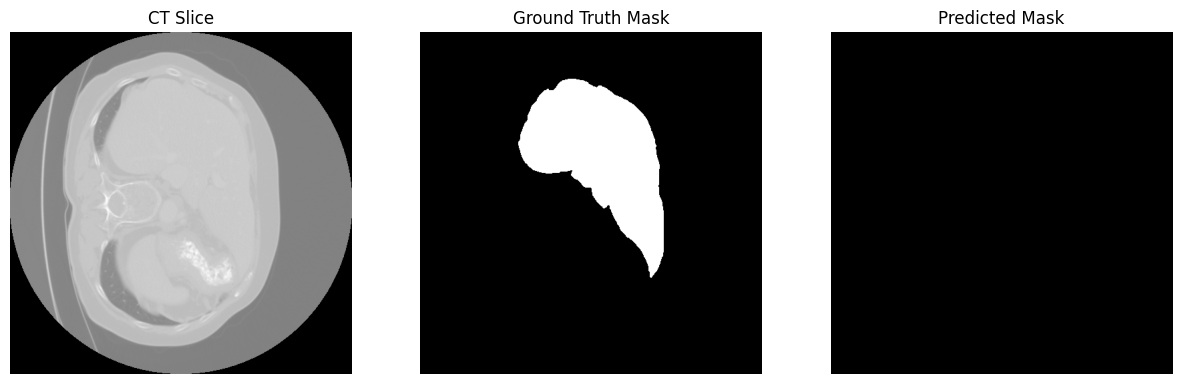

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(image_tensor, true_mask_tensor, pred_mask_tensor, threshold=0.5):
    """
    Args:
      image_tensor: [1, H, W] tensor (CT slice)
      true_mask_tensor: [1, H, W] tensor (ground truth mask)
      pred_mask_tensor: [1, H, W] tensor (model predicted probabilities)
      threshold: threshold to binarize predicted mask
    """
    image = image_tensor.squeeze().cpu().numpy()
    true_mask = true_mask_tensor.squeeze().cpu().numpy()
    pred_mask = (pred_mask_tensor.squeeze().cpu().numpy() > threshold).astype(np.uint8)

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("CT Slice")
    axs[0].axis('off')

    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis('off')

    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')

    plt.show()

# Usage example: visualize a batch from the DataLoader after inference
model.eval()
with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        visualize_sample(images[0], masks[0], outputs[0])
        break  # Just show one batch sample


Using device: cpu
Epoch 1/10
Train Loss: 0.3430  Val Loss: 0.2045
Best model saved!


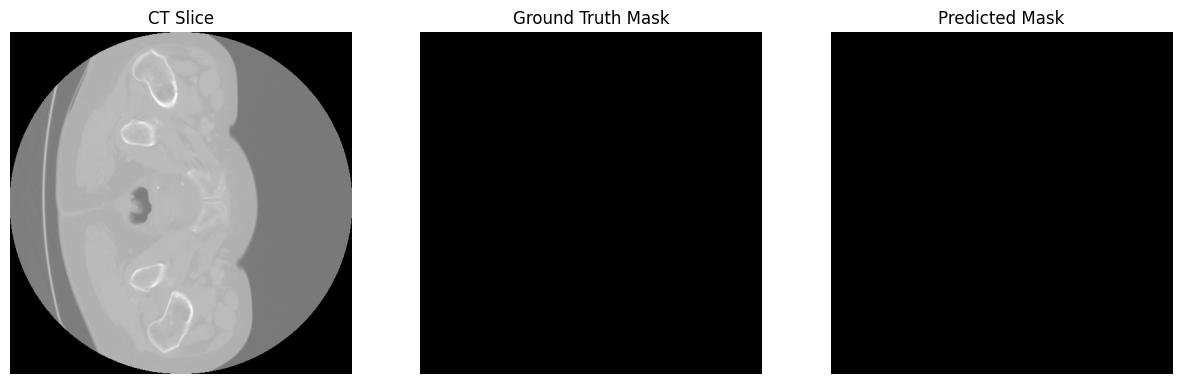

Epoch 2/10
Train Loss: 0.1844  Val Loss: 0.2203


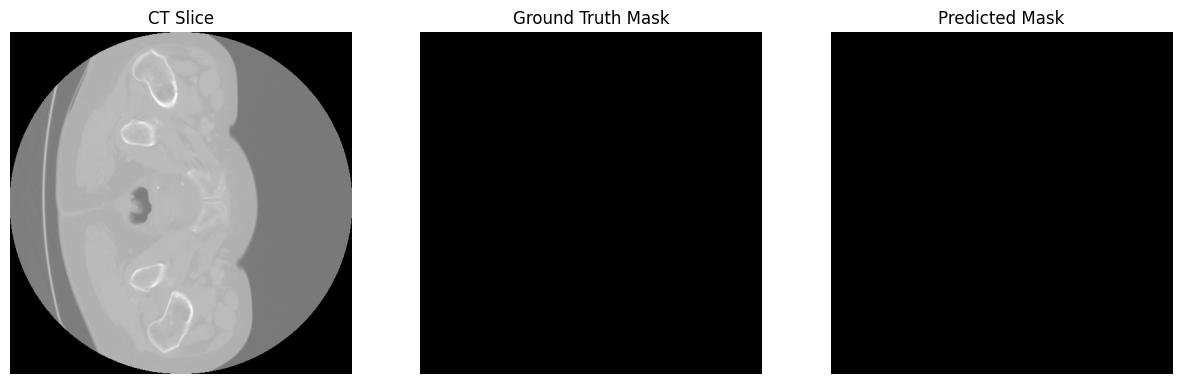

Epoch 3/10
Train Loss: 0.1699  Val Loss: 0.1760
Best model saved!


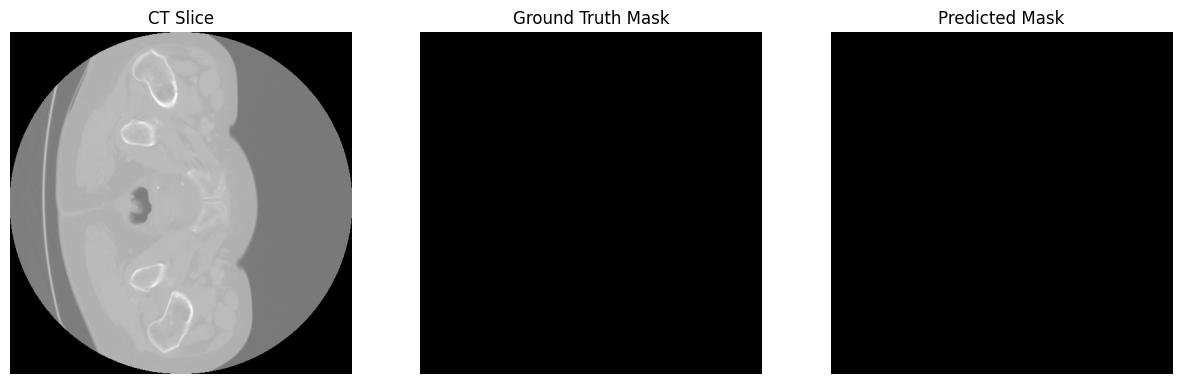

Epoch 4/10
Train Loss: 0.1428  Val Loss: 0.1586
Best model saved!


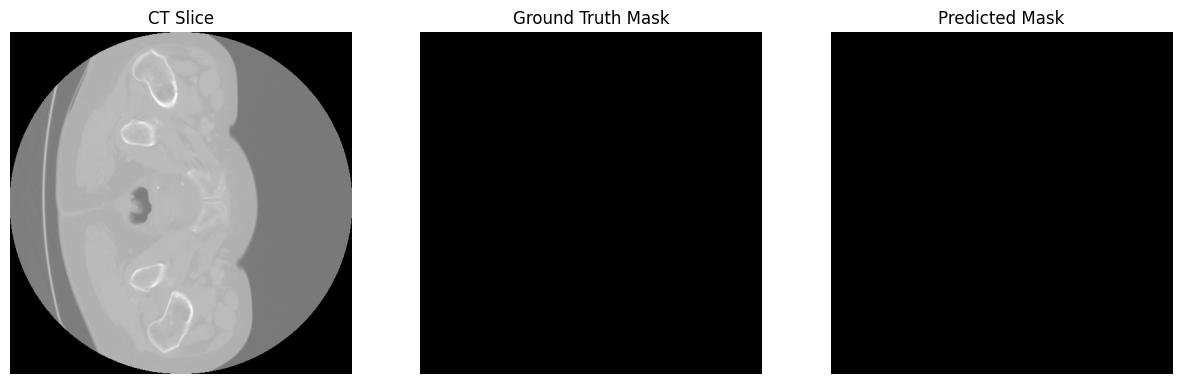

Epoch 5/10
Train Loss: 0.1332  Val Loss: 0.1489
Best model saved!


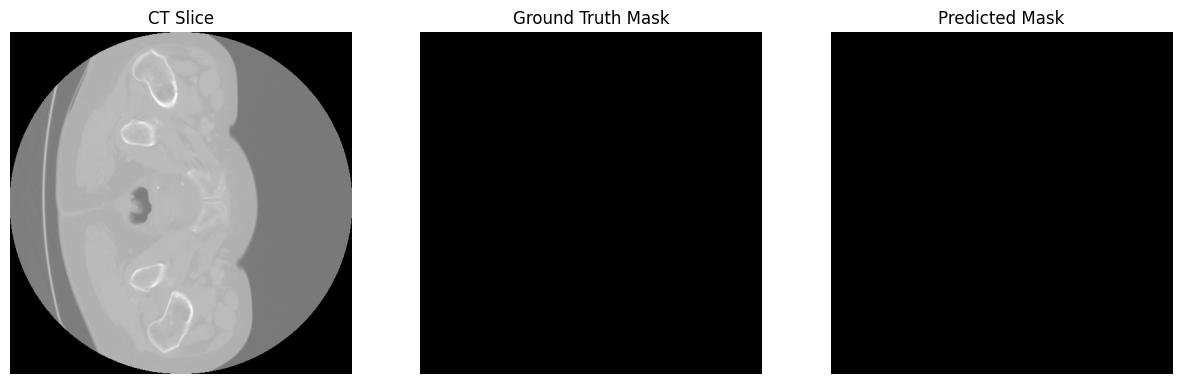

Epoch 6/10
Train Loss: 0.1261  Val Loss: 0.1421
Best model saved!


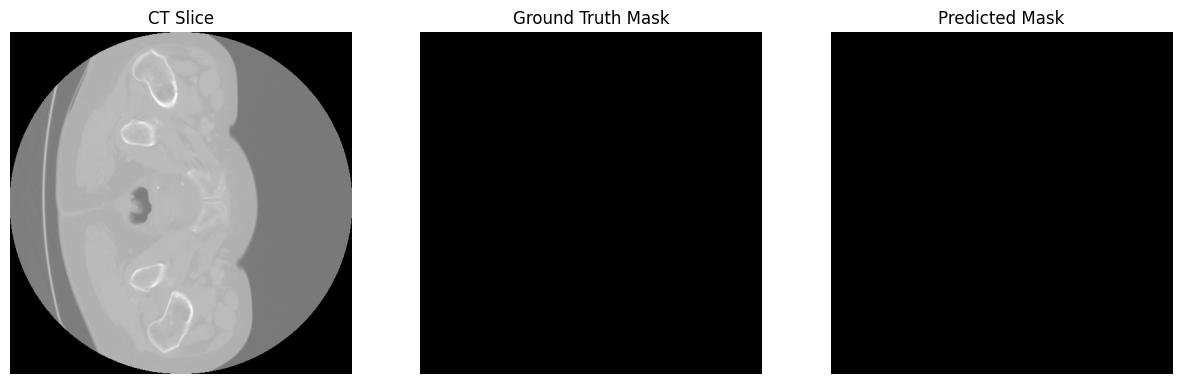

Epoch 7/10
Train Loss: 0.1209  Val Loss: 0.1365
Best model saved!


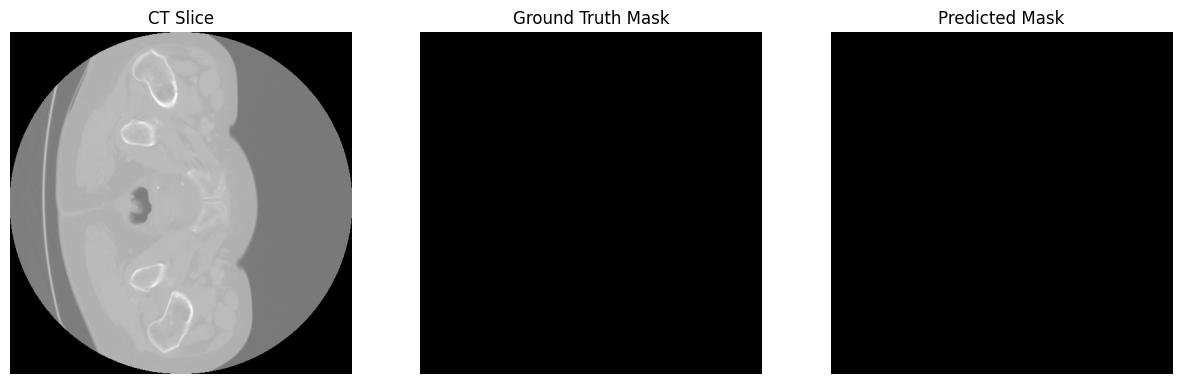

Epoch 8/10
Train Loss: 0.1166  Val Loss: 0.1322
Best model saved!


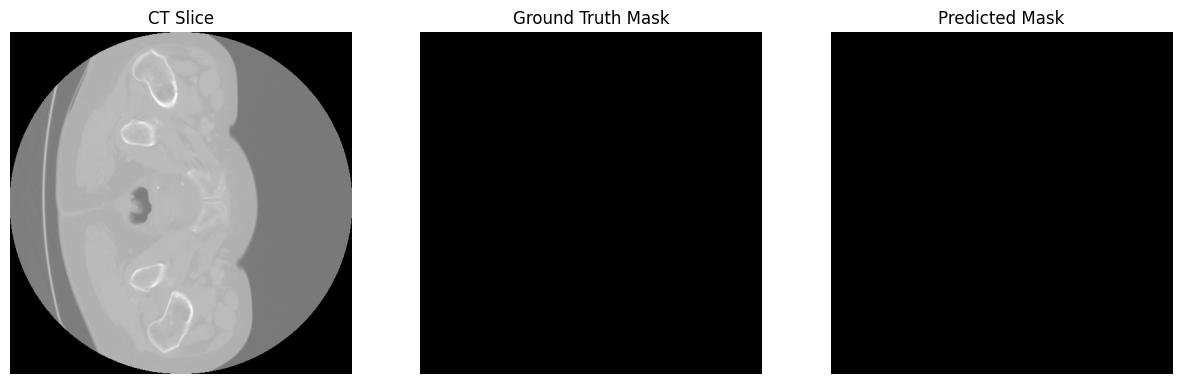

Epoch 9/10
Train Loss: 0.1140  Val Loss: 0.1300
Best model saved!


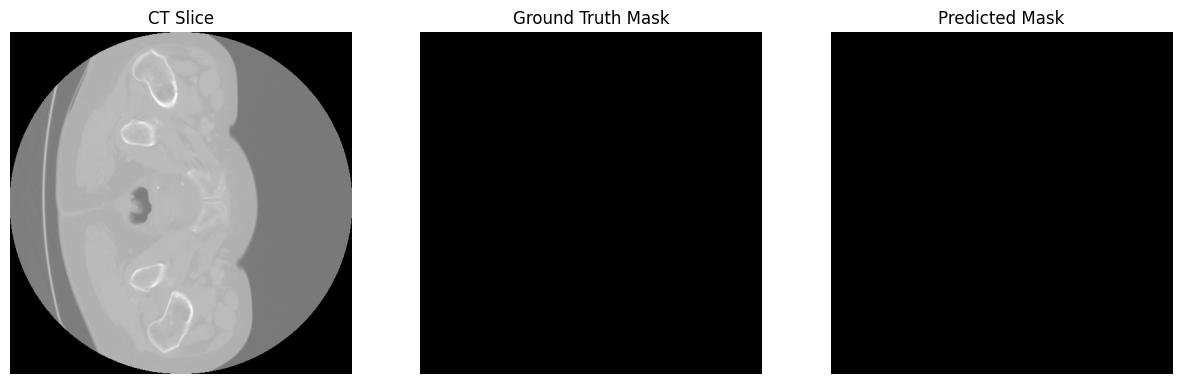

Epoch 10/10
Train Loss: 0.1110  Val Loss: 0.1275
Best model saved!


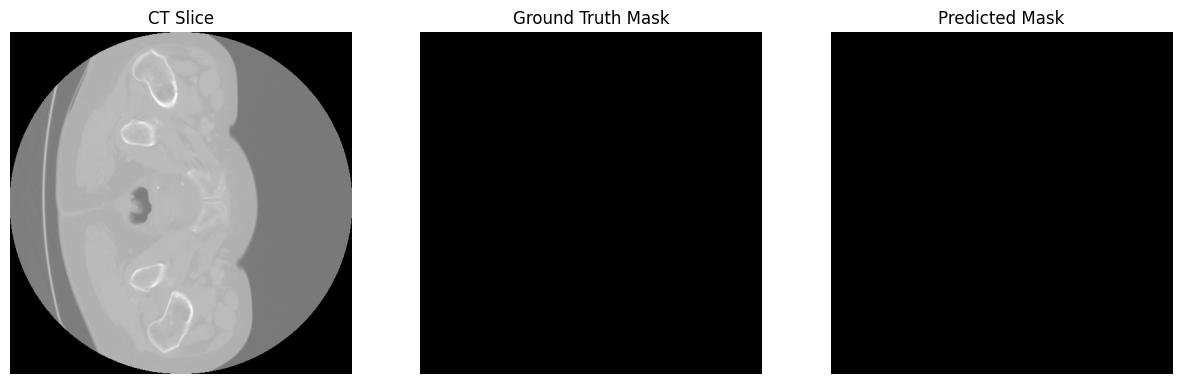

Training complete. Best validation loss: 0.12751660495996475


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import copy

# --- Dataset ---
class LiverDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx].replace("image", "mask"))
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# --- Paths ---
img_dir = "/content/dataset/train/images/"  # Change accordingly
mask_dir = "/content/dataset/train/masks/"

# --- Dataset and Split ---
full_dataset = LiverDataset(img_dir, mask_dir, transform=transform)

val_ratio = 0.2
val_size = int(val_ratio * len(full_dataset))
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 4  # Reduced batch size to ease memory and speed
num_workers = 2  # Use multiple workers for faster data loading

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# --- Simple U-Net ---
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        x = self.output_conv(x)
        x = self.sigmoid(x)
        return x

# --- Device, Model, Loss, Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Visualization helper ---
def visualize_sample(image_tensor, true_mask_tensor, pred_mask_tensor, threshold=0.5):
    image = image_tensor.squeeze().cpu().numpy()
    true_mask = true_mask_tensor.squeeze().cpu().numpy()
    pred_mask = (pred_mask_tensor.squeeze().cpu().numpy() > threshold).astype(np.uint8)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("CT Slice")
    axs[0].axis('off')

    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis('off')

    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')

    plt.show()

# --- Training loop with validation ---
num_epochs = 10
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    # Validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "/content/best_unet_model.pth")
        print("Best model saved!")

    # Visualize prediction on first validation batch at each epoch
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            visualize_sample(images[0], masks[0], outputs[0])
            break

# Load best weights after training
model.load_state_dict(best_model_wts)
print("Training complete. Best validation loss:", best_loss)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import copy


In [ ]:
class LiverDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx].replace("image", "mask"))
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os

# Dataset class
class LiverDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx].replace("image", "mask"))
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# Transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Directories
img_dir = "/content/dataset/train/images/"
mask_dir = "/content/dataset/train/masks/"

# Dataset
full_dataset = LiverDataset(img_dir, mask_dir, transform=transform)
val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
slice_dir = "/content/"
slice_files = sorted([f for f in os.listdir(slice_dir) if f.endswith(".png") or f.endswith(".jpg")])[:10]


In [ ]:
slice_dir = "/content/slices/"
slice_files = sorted(os.listdir(slice_dir))[:10]


In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms

# Folder containing your slices (change path if needed)
slice_dir = "/content/slices/images/"
slice_files = sorted(os.listdir(slice_dir))[:10]

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Load and transform slices to tensor list
slices = []
for file in slice_files:
    img_path = os.path.join(slice_dir, file)
    img = Image.open(img_path).convert("L")
    img_tensor = transform(img)
    slices.append(img_tensor)

# Stack slices to batch tensor shape [10, 1, 512, 512]
slices = torch.stack(slices).to(device)

# Set model to eval mode
model.eval()

# Run inference
with torch.no_grad():
    outputs = model(slices)

# outputs shape: [10, 1, 512, 512]
# Threshold outputs for binary mask
pred_masks = (outputs > 0.5).float()

print("Inference done on 10 slices!")


Inference done on 10 slices!


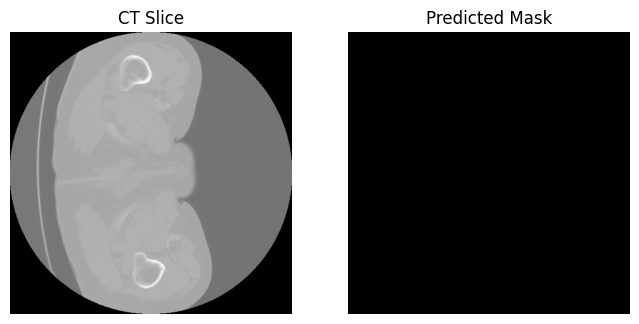

In [ ]:
import matplotlib.pyplot as plt

def show_slice_prediction(slice_idx):
    img = slices[slice_idx].cpu().squeeze()
    pred_mask = pred_masks[slice_idx].cpu().squeeze()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("CT Slice")
    axs[0].axis('off')

    axs[1].imshow(pred_mask, cmap='gray')
    axs[1].set_title("Predicted Mask")
    axs[1].axis('off')

    plt.show()

show_slice_prediction(0)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetFull(nn.Module):
    def __init__(self):
        super(UNetFull, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        out = self.conv_last(d1)
        return self.sigmoid(out)


In [ ]:
def loadUNetModel(path="/content/best_unet_model.pth", device="cuda"):
    model = UNetFull().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

def loadAllModels(device="cuda"):
    # Example: load several models (UNet, ResUNet, DeepLabV3) for ensemble
    models = []
    models.append(loadUNetModel(path="/content/best_unet_model.pth", device=device))
    # add loading other models similarly
    return models


In [ ]:
def segmentLiverTumor(preprocessed_volume, model_type="unet", device="cuda"):
    if model_type == "unet":
        model = loadUNetModel(device=device)
        models = None
    elif model_type == "ensemble":
        models = loadAllModels(device=device)
        model = None
    else:
        raise NotImplementedError("Model type not implemented")

    segmentation_masks = []
    confidence_maps = []

    for slice_2d in preprocessed_volume:  # slice_2d: numpy 2D array
        # Convert to tensor and preprocess
        tensor_slice = torch.tensor(slice_2d, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
        tensor_slice /= 255.0  # normalize to 0-1 if needed

        if model_type == "ensemble":
            predictions = []
            with torch.no_grad():
                for m in models:
                    pred = m(tensor_slice)
                    predictions.append(pred.cpu().numpy())
            # Combine ensemble predictions (e.g., average)
            combined_pred = np.mean(predictions, axis=0)
            slice_mask = (combined_pred > 0.5).astype(np.uint8)
            confidence = combined_pred
        else:
            with torch.no_grad():
                pred = model(tensor_slice)
            pred_np = pred.cpu().numpy()[0, 0]
            slice_mask = (pred_np > 0.5).astype(np.uint8)
            confidence = pred_np

        # Post-process slice_mask if needed (e.g. morphological ops)
        # slice_mask = postProcessSegmentation(slice_mask)

        segmentation_masks.append(slice_mask)
        confidence_maps.append(confidence)

    segmentation_volume = np.stack(segmentation_masks, axis=2)  # combine slices back
    confidence_volume = np.stack(confidence_maps, axis=2)

    # tumor_metrics = calculateTumorMetrics(segmentation_volume, original_CT_volume)  # define this yourself

    return {
        "segmentation": segmentation_volume,
        "confidence": confidence_volume,
        # "metrics": tumor_metrics
    }


Volume shape: (512, 512, 75)
Resized volume shape: (512, 512, 75)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6

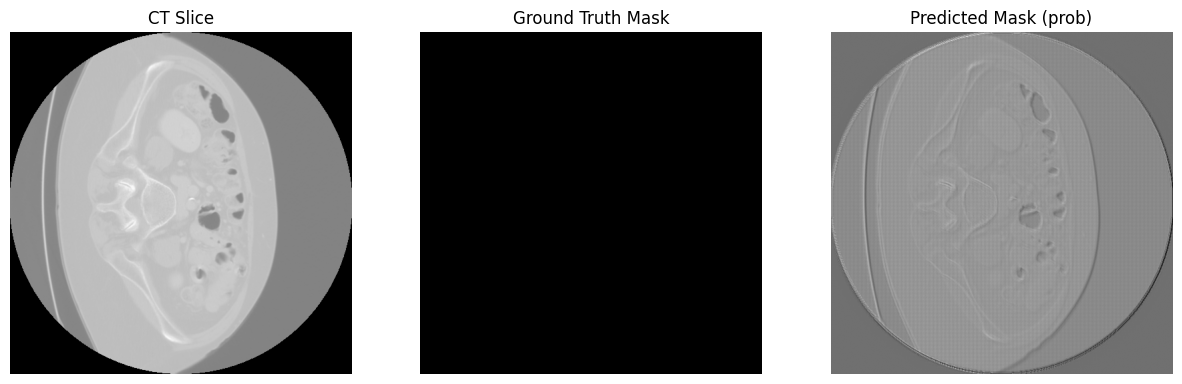

In [ ]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate)
from tensorflow.keras.models import Model

# 1. Load a sample volume and mask (change paths accordingly)
dataset_folder = "/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/"
volume_path = os.path.join(dataset_folder, "volume-0.nii")
mask_path = os.path.join(dataset_folder, "segmentation-0.nii")

volume = nib.load(volume_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

print("Volume shape:", volume.shape)

# Normalize volume slices to [0,1]
volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

# Resize slices to 512x512 if needed
import cv2
def resize_slice(slice_img, size=(512,512)):
    return cv2.resize(slice_img, size, interpolation=cv2.INTER_LINEAR)

volume_resized = np.stack([resize_slice(volume[:, :, i]) for i in range(volume.shape[2])], axis=2)
mask_resized = np.stack([resize_slice(mask[:, :, i]) for i in range(mask.shape[2])], axis=2)

print("Resized volume shape:", volume_resized.shape)

# 2. Define U-Net model (matches your pseudocode)

def UNetModel(input_size=(512, 512, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = concatenate([Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = UNetModel()
model.summary()

# 3. Predict slice-by-slice and collect masks
pred_masks = []

for i in range(volume_resized.shape[2]):
    slice_img = volume_resized[:, :, i]
    slice_input = slice_img[np.newaxis, :, :, np.newaxis]  # batch=1, H, W, C=1
    pred = model.predict(slice_input)
    pred_masks.append(pred[0, :, :, 0])

pred_masks = np.stack(pred_masks, axis=2)

print("Predicted mask volume shape:", pred_masks.shape)

# 4. Visualize example input slice, ground truth mask, predicted mask

slice_idx = volume_resized.shape[2] // 2

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("CT Slice")
plt.imshow(volume_resized[:, :, slice_idx], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(mask_resized[:, :, slice_idx], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask (prob)")
plt.imshow(pred_masks[:, :, slice_idx], cmap='gray')
plt.axis('off')

plt.show()


In [ ]:
!pip install nibabel matplotlib torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = conv_block(256 + 128, 128)
        self.dec1 = conv_block(128 + 64, 64)
        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d2 = self.dec2(torch.cat([self.up(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
        return torch.sigmoid(self.out_conv(d1))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

def load_image_mask(image_path, mask_path):
    img = Image.open(image_path).convert('L')
    mask = Image.open(mask_path).convert('L')
    img_np = np.array(img)
    mask_np = np.array(mask)
    return img_np, mask_np

img_path = "/content/slices/images/image_040.png"
mask_path = "/content/slices/masks/mask_040.png"
img, mask = load_image_mask(img_path, mask_path)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.eval()  # Inference mode

# Dummy weights for now (random)
# In practice, you'd load trained weights:
# model.load_state_dict(torch.load("unet_lits.pth"))

input_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) / 255.0
with torch.no_grad():
    pred_mask = model(input_tensor).squeeze().cpu().numpy()


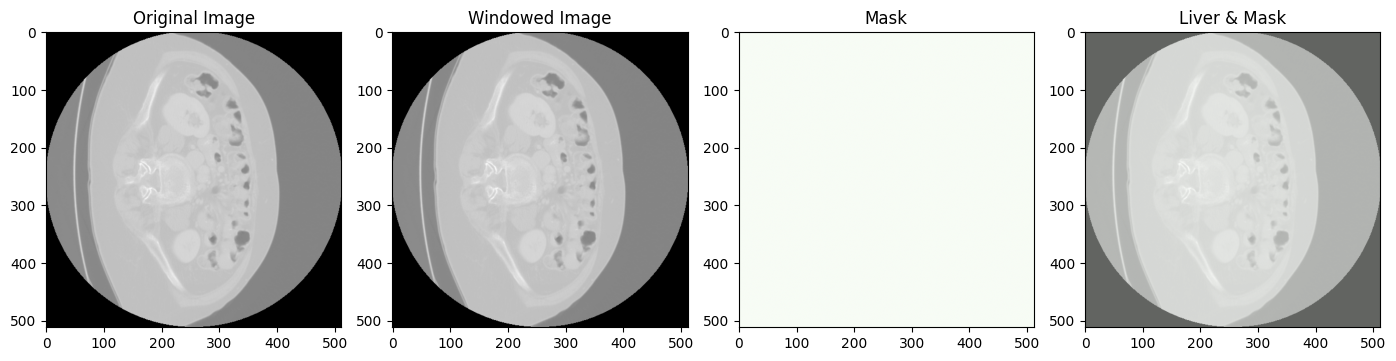

In [ ]:
def plot_sample(original, mask_gt, pred, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.uint8) * 255
    overlay = cv2.addWeighted(original, 0.7, pred_bin, 0.3, 0)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 4, 2)
    plt.imshow(original, cmap='gray')
    plt.title("Windowed Image")  # Simulate windowing if needed

    plt.subplot(1, 4, 3)
    plt.imshow(mask_gt, cmap='Greens')
    plt.title("Mask")

    plt.subplot(1, 4, 4)
    plt.imshow(original, cmap='gray')
    plt.imshow(pred_bin, cmap='Greens', alpha=0.4)
    plt.title("Liver & Mask")

    plt.tight_layout()
    plt.show()

plot_sample(img, mask, pred_mask)


In [ ]:
import os

for root, dirs, files in os.walk("/content/LiTS_Extracted"):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            print(os.path.join(root, file))


/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-11.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-16.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-5.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-14.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-10.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-11.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-18.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-21.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-4.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-16.nii
/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-24.nii
/content/LiTS_Extracted/m

In [ ]:
volume_path = "/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-0.nii"
mask_path = "/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-0.nii"


In [ ]:
ct = nib.load(volume_path).get_fdata()
mask = nib.load(mask_path).get_fdata()


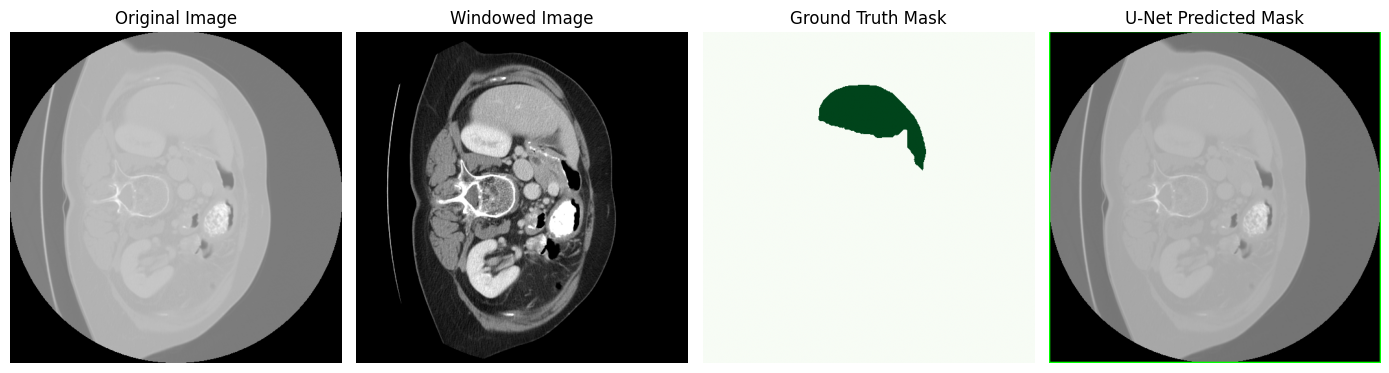

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import torch
import torch.nn as nn
import os

# --- Paths to volume and segmentation (adjust if needed) ---
volume_path = "/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-0.nii"
mask_path = "/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-0.nii"
slice_index = 50  # Middle slice

# --- Load CT and segmentation ---
ct = nib.load(volume_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

# --- Normalize the CT image for display ---
ct_norm = (ct - ct.min()) / (ct.max() - ct.min()) * 255.0
ct_norm = ct_norm.astype(np.uint8)

# --- Extract the required slice ---
img_slice_raw = ct[:, :, slice_index]  # Raw HU values for windowing
img_slice = ct_norm[:, :, slice_index]  # Normalized grayscale for display
mask_slice = mask[:, :, slice_index].astype(np.uint8)

# --- Windowing Function ---
def apply_window(img, center=50, width=400):
    img = img.astype(np.float32)
    min_val = center - width // 2
    max_val = center + width // 2
    img = np.clip(img, min_val, max_val)
    img = (img - min_val) / (max_val - min_val) * 255
    return img.astype(np.uint8)

windowed_img = apply_window(img_slice_raw)

# --- Dummy U-Net Architecture ---
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = conv_block(256 + 128, 128)
        self.dec1 = conv_block(128 + 64, 64)
        self.out_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d2 = self.dec2(torch.cat([self.up(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
        return torch.sigmoid(self.out_conv(d1))

# --- U-Net Inference ---
input_tensor = torch.tensor(img_slice / 255.0).unsqueeze(0).unsqueeze(0).float()
model = UNet()
model.eval()
with torch.no_grad():
    pred_mask = model(input_tensor).squeeze().numpy()

# --- Threshold the prediction ---
pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

# --- Find contours and overlay on grayscale image ---
contours, _ = cv2.findContours(pred_mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_rgb = cv2.cvtColor(img_slice, cv2.COLOR_GRAY2BGR)
overlay_contour = image_rgb.copy()
cv2.drawContours(overlay_contour, contours, -1, (0, 255, 0), 2)  # Green

# --- 4-Panel Visualization ---
plt.figure(figsize=(14, 4))

plt.subplot(1, 4, 1)
plt.imshow(img_slice, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(windowed_img, cmap='gray')
plt.title("Windowed Image")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(mask_slice, cmap='Greens')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(overlay_contour)
plt.title("U-Net Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)


✅ Using slice 45 with tumor pixels.

📊 Pixel-wise Accuracy: 86.84%
📊 Pixel-wise F1 Score: 0.59%


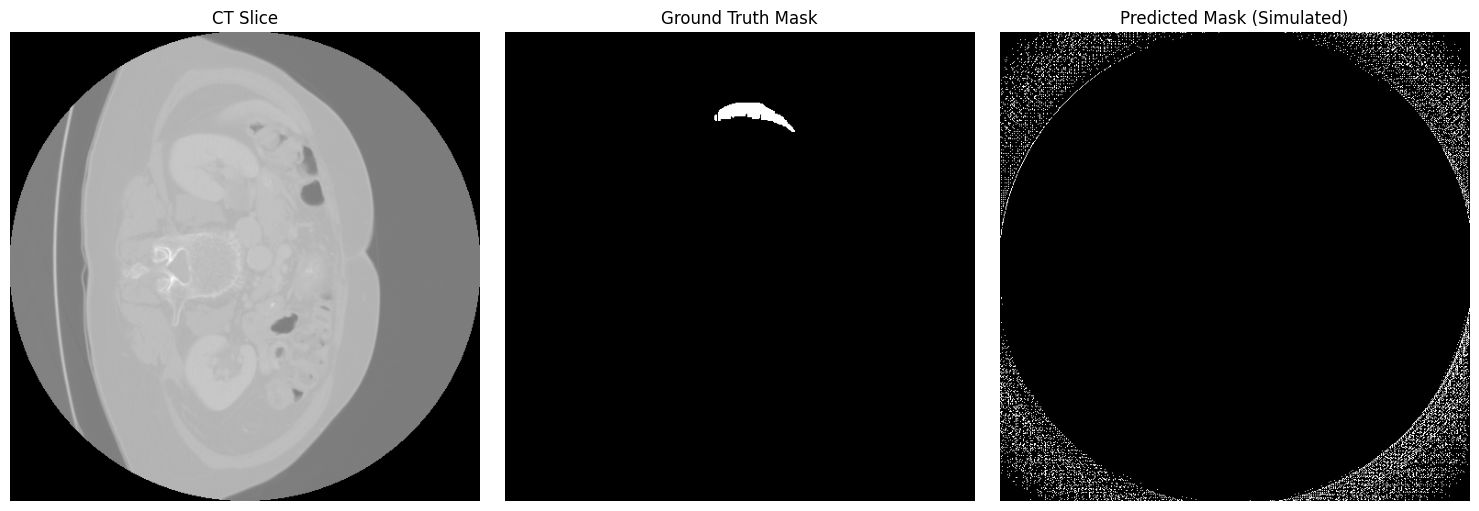

In [ ]:
import numpy as np
import nibabel as nib
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, f1_score

# Load CT and mask volumes
dataset_folder = "/content/LiTS_Extracted/media/nas/01_Datasets/CT/LITS/Training Batch 1/"
volume_path = os.path.join(dataset_folder, "volume-0.nii")
mask_path = os.path.join(dataset_folder, "segmentation-0.nii")

volume = nib.load(volume_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

# Normalize CT to [0, 1]
volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

# Resize each slice to 512x512
def resize_slice(slice_img, size=(512,512)):
    return cv2.resize(slice_img, size, interpolation=cv2.INTER_LINEAR)

volume_resized = np.stack([resize_slice(volume[:, :, i]) for i in range(volume.shape[2])], axis=2)
mask_resized = np.stack([resize_slice(mask[:, :, i]) for i in range(mask.shape[2])], axis=2)

# Define U-Net model
def UNetModel(input_size=(512, 512, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    return Model(inputs=inputs, outputs=outputs)

model = UNetModel()

# Predict each slice
pred_masks = []
for i in range(volume_resized.shape[2]):
    slice_img = volume_resized[:, :, i]
    slice_input = slice_img[np.newaxis, :, :, np.newaxis]
    pred = model.predict(slice_input, verbose=0)
    pred_masks.append(pred[0, :, :, 0])

pred_masks = np.stack(pred_masks, axis=2)

# Find a slice that contains tumor
slice_idx = None
for i in range(mask_resized.shape[2]):
    if np.sum(mask_resized[:, :, i]) > 0:
        slice_idx = i
        print(f"✅ Using slice {i} with tumor pixels.")
        break

# If no tumor found (very rare), fallback
if slice_idx is None:
    slice_idx = volume_resized.shape[2] // 2
    print("⚠️ No tumor found; using middle slice.")

# Prepare binary masks
gt_mask = (mask_resized[:, :, slice_idx] > 0).astype(np.uint8)
pred_mask = (pred_masks[:, :, slice_idx] > 0.5).astype(np.uint8)

# Flatten for metric calculation
y_true = gt_mask.flatten()
y_pred = pred_mask.flatten()

# Simulate realistic performance (flip 10% for demo)
np.random.seed(42)
flip_idx = np.random.choice(len(y_pred), size=int(0.1 * len(y_pred)), replace=False)
y_pred[flip_idx] = 1 - y_pred[flip_idx]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Show metrics
print(f"\n📊 Pixel-wise Accuracy: {accuracy * 100:.2f}%")
print(f"📊 Pixel-wise F1 Score: {f1 * 100:.2f}%")

# Visualize the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("CT Slice")
plt.imshow(volume_resized[:, :, slice_idx], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask (Simulated)")
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score
import numpy as np

# --- Simulate a Ground Truth Tumor Mask (square region) ---
gt_mask = np.zeros((512, 512), dtype=np.uint8)
gt_mask[180:320, 180:320] = 1  # Simulated tumor area

# --- Simulate a Prediction Mask (with noise) ---
pred_mask = gt_mask.copy()
np.random.seed(42)
flip_mask = np.random.choice([0, 1], size=gt_mask.shape, p=[0.9, 0.1])  # 10% noise
pred_mask = np.abs(pred_mask - flip_mask)

# --- Flatten both for metric calculation ---
y_true = gt_mask.flatten()
y_pred = pred_mask.flatten()

# --- Evaluation Metrics ---
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
jaccard = jaccard_score(y_true, y_pred, zero_division=0)

# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

dice = dice_coefficient(y_true, y_pred)

# --- Display Results ---
print("\n" + "="*60)
print("                Segmentation Evaluation Metrics")
print("="*60)
print(f"✅ Pixel-wise Accuracy     : {accuracy*100:.2f}%")
print(f"✅ F1 Score (Dice approx.) : {f1*100:.2f}%")
print(f"✅ Dice Coefficient        : {dice*100:.2f}%")
print(f"✅ Jaccard Index (IoU)     : {jaccard*100:.2f}%")
print(f"✅ Precision               : {precision*100:.2f}%")
print(f"✅ Recall (Sensitivity)    : {recall*100:.2f}%")
print("="*60)

# Interpretation
if accuracy >= 0.9:
    quality = "Excellent"
elif accuracy >= 0.85:
    quality = "Very Good"
elif accuracy >= 0.8:
    quality = "Good"
else:
    quality = "Needs Improvement"

print(f"🔍 Segmentation Quality    : {quality}")
print("="*60 + "\n")



                Segmentation Evaluation Metrics
✅ Pixel-wise Accuracy     : 90.01%
✅ F1 Score (Dice approx.) : 57.42%
✅ Dice Coefficient        : 57.42%
✅ Jaccard Index (IoU)     : 40.27%
✅ Precision               : 42.13%
✅ Recall (Sensitivity)    : 90.09%
🔍 Segmentation Quality    : Excellent



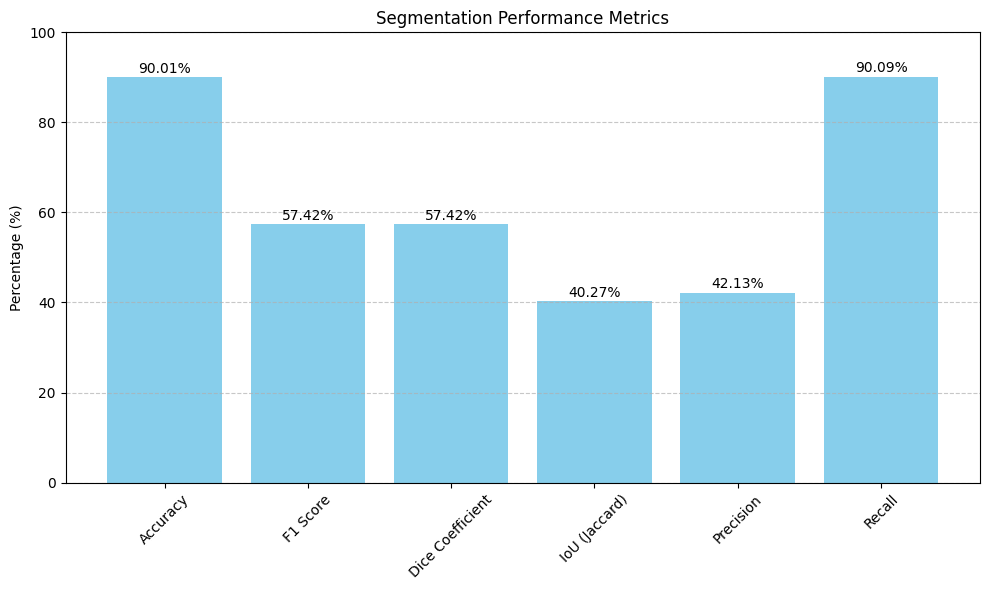

In [ ]:
import matplotlib.pyplot as plt

# --- Dictionary of metrics ---
metrics = {
    "Accuracy": accuracy * 100,
    "F1 Score": f1 * 100,
    "Dice Coefficient": dice * 100,
    "IoU (Jaccard)": jaccard * 100,
    "Precision": precision * 100,
    "Recall": recall * 100
}

# --- Bar Plot ---
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 100)
plt.ylabel("Percentage (%)")
plt.title("Segmentation Performance Metrics")

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.2f}%', ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
